RMSE: 62.6, MAE: 47.1, R²: 0.91


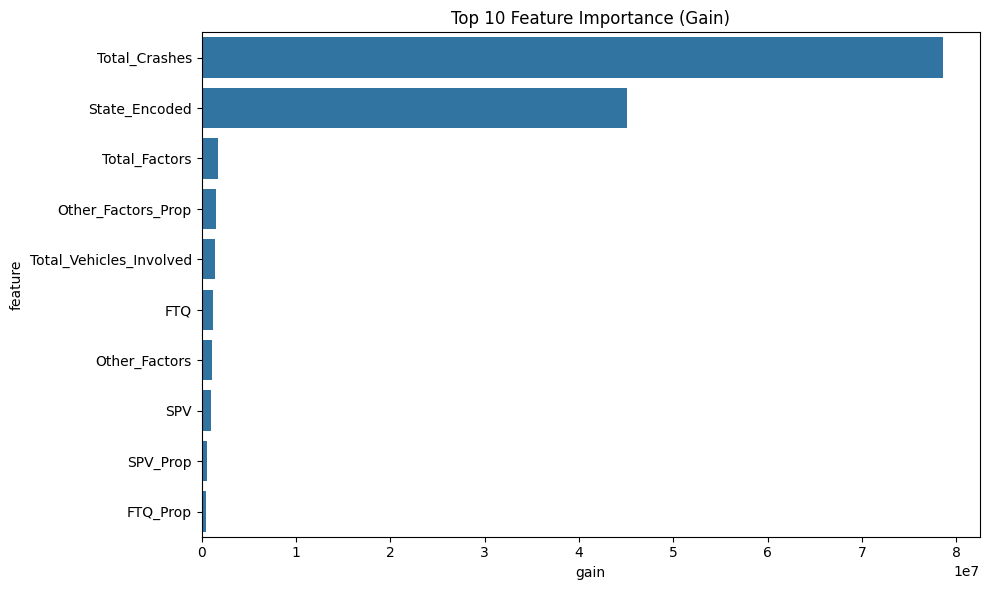

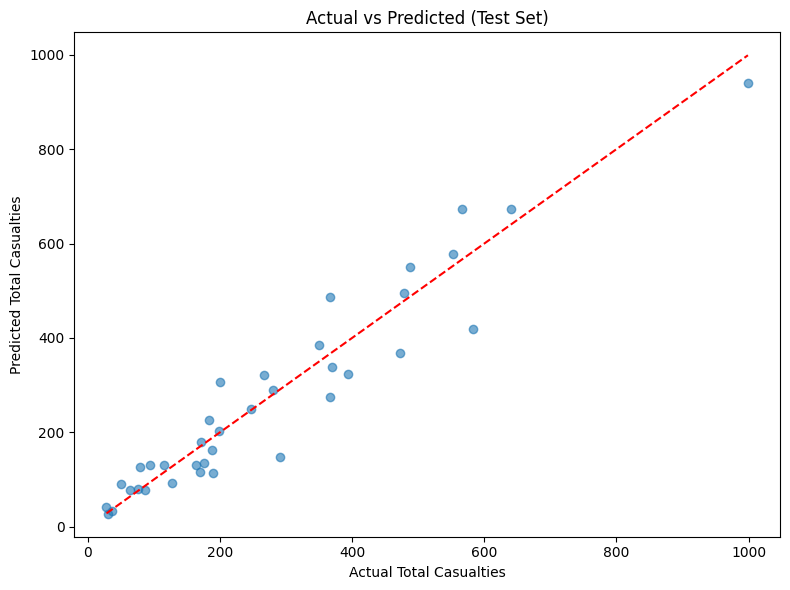

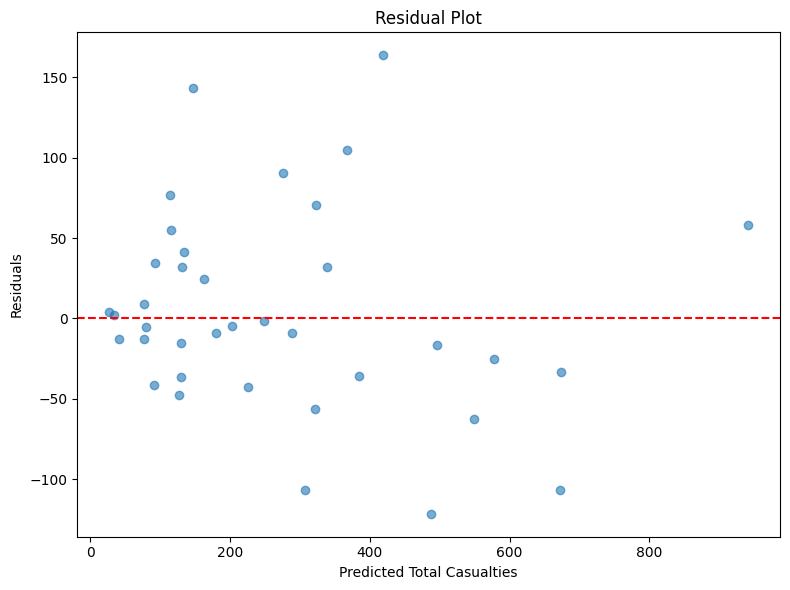

Train Score: 0.98, Test Score: 0.91
RMSE: 62.6, MAE: 47.1, R²: 0.91


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from io import StringIO

# Load data (replace with actual file path)
file_content = """Quarter,State,Total_Crashes,Num_Injured,..."""  # full CSV content
df = pd.read_csv("Nigeria Crash Data P.csv")

# Prepare features and target
target = 'Total_Casualties'
features_to_drop = [
    'Quarter', 'State', 'Num_Injured', 'Num_Killed', 'Quarter_Date',
    'Casualty_Rate', 'Fatality_Rate', 'Vehicles_per_Crash',
    'Severe_Crash', 'High_Casualty', 'Quarter_Num',
    # one-hot state columns (all starting with 'State_')
] + [col for col in df.columns if col.startswith('State_') and col != 'State_Encoded'] \
  + ['Region', 'Region_Encoded'] \
  + [col for col in df.columns if col.startswith('Region_')]

X = df.drop(columns=[target] + features_to_drop)
y = df[target]

# Ensure State_Encoded is categorical
X['State_Encoded'] = X['State_Encoded'].astype('category')

# Time-based split (last quarter as test)
train_idx = df['Quarter'] != 'Q1 2024'
test_idx = df['Quarter'] == 'Q1 2024'

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Train LightGBM
model = LGBMRegressor(random_state=42, verbose=-1)
model.fit(X_train, y_train, categorical_feature=['State_Encoded'])

# Predict
y_pred = model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.1f}, MAE: {mae:.1f}, R²: {r2:.2f}")

# Feature importance
importance = pd.DataFrame({
    'feature': X_train.columns,
    'gain': model.booster_.feature_importance(importance_type='gain')
}).sort_values('gain', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance.head(10), x='gain', y='feature')
plt.title('Top 10 Feature Importance (Gain)')
plt.tight_layout()
plt.show()

# Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Total Casualties')
plt.ylabel('Predicted Total Casualties')
plt.title('Actual vs Predicted (Test Set)')
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Total Casualties')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

Train_Score = model.score(X_train, y_train)
Test_Score = model.score(X_test, y_test)
print(f"Train Score: {Train_Score:.2f}, Test Score: {Test_Score:.2f}")
print(f"RMSE: {rmse:.1f}, MAE: {mae:.1f}, R²: {r2:.2f}")